# Урок 4. Семантическая сегментация.

Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета.
MS COCO Библиотеки: [Python, Tensorflow]

In [1]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

2021-09-24 12:22:46.002349: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Загрузка датасета COCO и COCO API

In [2]:
# !mkdir -p data

# !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
# !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
# !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

# !cd data && unzip -q train2017.zip
# !cd data && unzip -q val2017.zip
# !cd data && unzip -q annotations_trainval2017.zip

# !cd data && git clone https://github.com/cocodataset/cocoapi
# !cd data/cocoapi/PythonAPI && make

## Подготовка COCO API

In [3]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

In [4]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        # dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [5]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)


    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [6]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=16.86s)
creating index...
index created!
loading annotations into memory...
Done (t=0.87s)
creating index...
index created!


Изображений в исходном датасете очень много. Уменьшим их к-во.

In [7]:
COCO_dataset_train.cat_ids=COCO_dataset_train.cat_ids[:1000]
COCO_dataset_train.img_list=COCO_dataset_train.img_list[:1000]

COCO_dataset_val.cat_ids=COCO_dataset_val.cat_ids[:200]
COCO_dataset_val.img_list=COCO_dataset_val.img_list[:200]

In [8]:
len(COCO_dataset_train.img_list), len(COCO_dataset_train.cat_ids)

(1000, 1)

In [9]:
len(COCO_dataset_val.img_list), len(COCO_dataset_val.cat_ids)

(200, 1)

In [10]:
NUM_EPOCHS = 10
BATCH_SIZE = 8
inp_size = 256

In [ ]:
# Сформируем валлидационный и тестовый датасеты. Их мы будем подавать модель.

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,inp_size=inp_size)

val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=inp_size)

2021-09-24 12:23:11.544100: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-24 12:23:11.562929: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2799925000 Hz
2021-09-24 12:23:11.815300: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 25.62M (26869760 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-09-24 12:23:11.816482: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 23.06M (24182784 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


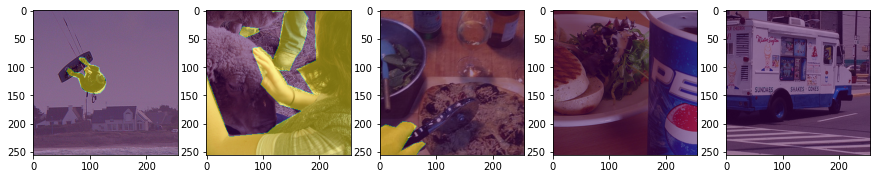

In [12]:
# Выполним визуализацию 

img, mask = next(iter(val_ds.take(1)))

fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img[i])
    ax.imshow(mask[...,0][i],alpha=0.5)
plt.show()

# Создадаим класс с описанием параметров нейросети. 

In [26]:
WEIGHT_DECAY = 0.001

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

args = {'padding':'same', 'activation': 'relu','kernel_regularizer':wd}

In [27]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((inp_size, inp_size, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), **args)(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), **args)(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), **args)(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), **args)(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), **args)(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), **args)(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), **args)(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3),**args)(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), **args)(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), **args)(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), **args)(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), **args)(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), **args)(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), **args)(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), **args)(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), **args)(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), **args)(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [28]:
# Directory where the checkpoints will be saved

checkpoint_dir = './checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_prefix,
                                save_freq=1,
                                save_weights_only=True)

In [29]:
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [36]:
hist = model.fit(
                 train_ds, 
                 batch_size=BATCH_SIZE,
                 epochs=NUM_EPOCHS,
                 validation_data=val_ds,
                 callbacks=[checkpoint_callback]
               )

Epoch 1/10
125/125 [==============================] - 3039s 24s/step - loss: 0.5491 - accuracy: 0.7870 - val_loss: 0.5847 - val_accuracy: 0.7573
Epoch 2/10
125/125 [==============================] - 4090s 33s/step - loss: 0.5139 - accuracy: 0.7868 - val_loss: 0.5765 - val_accuracy: 0.7573
Epoch 3/10
125/125 [==============================] - 1618s 13s/step - loss: 0.5159 - accuracy: 0.7867 - val_loss: 0.5479 - val_accuracy: 0.7573
Epoch 4/10
125/125 [==============================] - 1020s 8s/step - loss: 0.4939 - accuracy: 0.7935 - val_loss: 0.5380 - val_accuracy: 0.7573
Epoch 5/10
125/125 [==============================] - 896s 7s/step - loss: 0.4871 - accuracy: 0.7911 - val_loss: 0.5718 - val_accuracy: 0.7573
Epoch 6/10
125/125 [==============================] - 878s 7s/step - loss: 0.4986 - accuracy: 0.7829 - val_loss: 0.5532 - val_accuracy: 0.7573
Epoch 7/10
125/125 [==============================] - 977s 8s/step - loss: 0.4870 - accuracy: 0.7862 - val_loss: 0.5304 - val_accuracy:

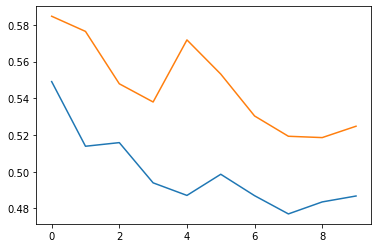

In [37]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

### Визуально проверим качество обученной модели.

In [38]:
img, mask = next(iter(val_ds.take(1)))

In [39]:
masks_pred = model.predict(img)

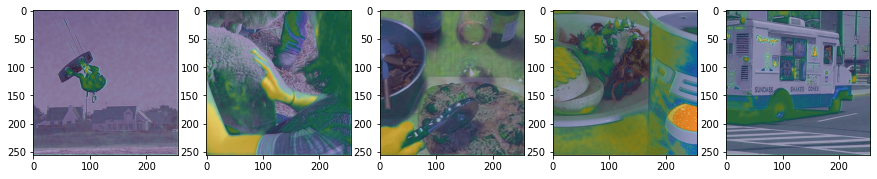

In [43]:
fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img[i])
    ax.imshow(masks_pred[...,0][i],alpha=0.5)
plt.show()

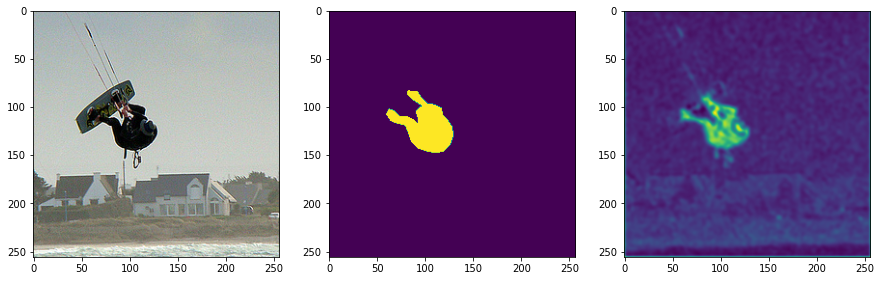

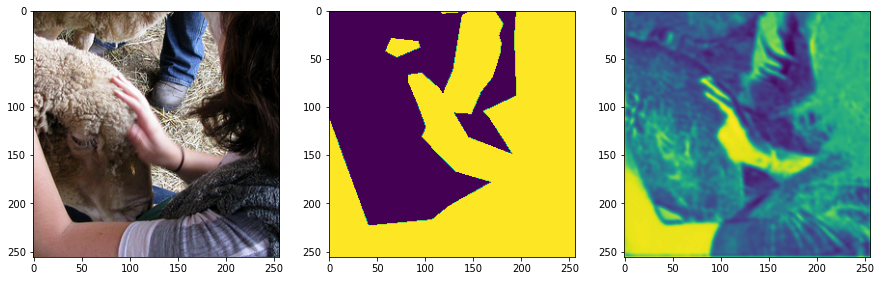

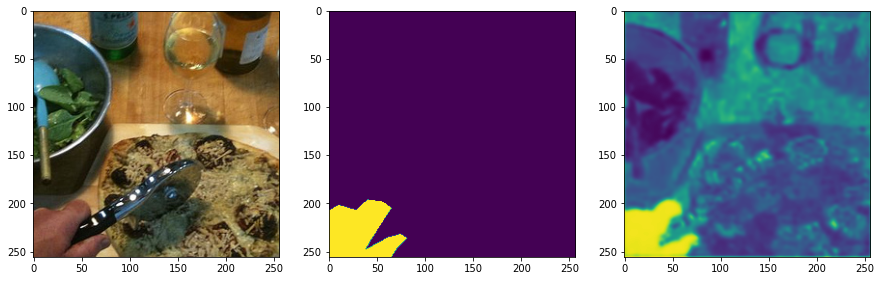

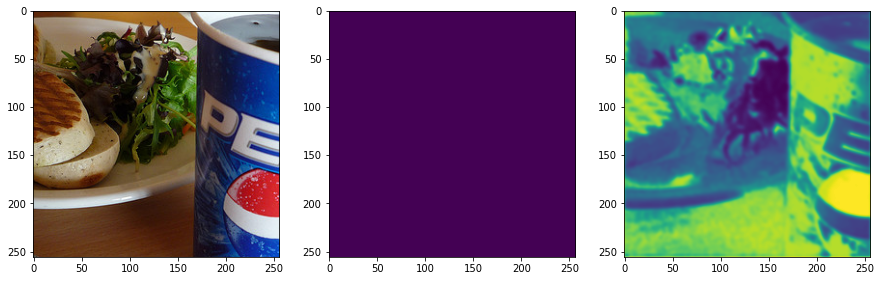

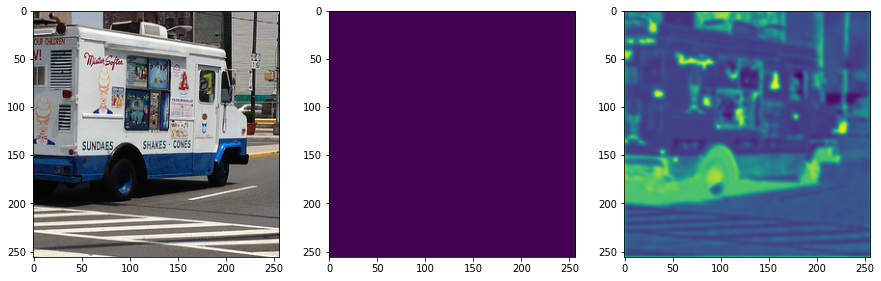

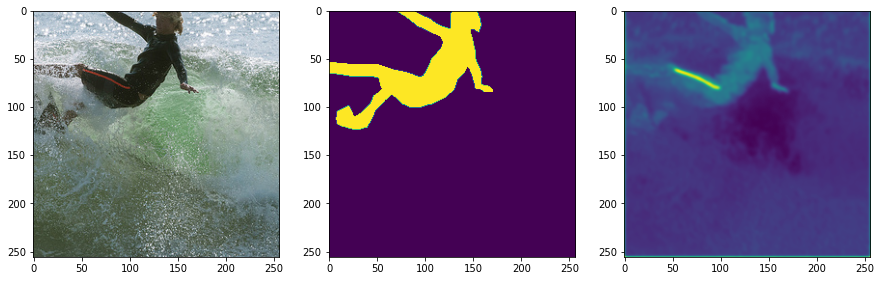

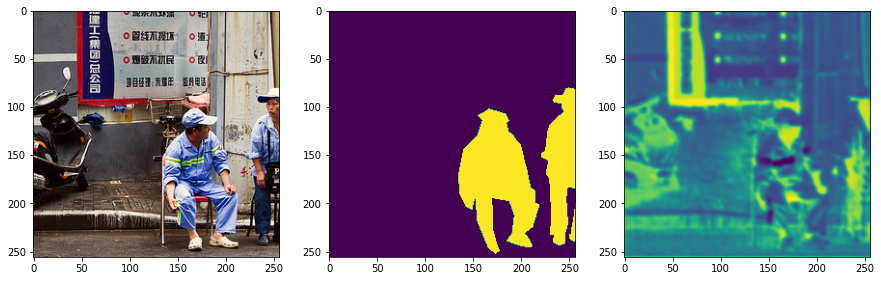

In [44]:
for i in range(7):
    fig, ax  = plt.subplots(1,3, figsize=(15,6))
    ax[0].imshow(img[i])
    ax[1].imshow(mask[i])
    ax[2].imshow(masks_pred[i])
    plt.show()

## Выводы: 
   Если судить по логам, качество начиная с первой эпохи практически не улучшается. Модель сети взята из урока. Судя повсему ее нужно будет переработать. 